In [1]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Conv1D,Conv2D,Flatten,BatchNormalization,MaxPooling1D,Dropout,Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,MaxPooling2D,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam,SGD
import datetime
from tensorflow.keras.utils import plot_model
import os
import flask
import json


# def load_dataset():

ddata = pd.read_csv('./final_1/final_1M.csv')

In [2]:
df = ddata
# df = ddata[ddata['Label'] != 'DDOS']

In [3]:
# drop columns
df.drop(['Timestamp','Fwd Header Len'], axis=1, inplace=True)
df.drop(['Protocol','Dst Port'], axis=1, inplace=True)

In [4]:
# duplicated
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

389456


In [5]:
df.dropna(axis=0, inplace=True, how="any")

In [6]:
# Checking if all values are finite.
np.all(np.isfinite(df.drop(['Label'], axis=1)))

# drop inf
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True,how='any',axis=0)


In [7]:
# df = df[df['Label']!='Password_attack']
# df = df[df['Label']!='DDOS']

# df.drop(['Protocol','Dst Port'],axis=1,inplace=True)
# df.drop(['Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'], axis=1,inplace=True)

# drop std < 0.01
dataset_std = df.std(numeric_only=True)
columns_to_drop = [column for column, std in dataset_std.iteritems() if std < 0.01]
print(columns_to_drop)
df.drop(columns=columns_to_drop, inplace=True)

C:\Users\fancyma\AppData\Local\Temp\ipykernel_22160\37678939.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  columns_to_drop = [column for column, std in dataset_std.iteritems() if std < 0.01]


['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg']


In [8]:
dataset_corr = df.corr()
dataset_corr.head(5)

C:\Users\fancyma\AppData\Local\Temp\ipykernel_22160\306764757.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_corr = df.corr()


,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Flow Duration,1.000000,-0.000552,0.003666,0.000472,0.002727,0.011058,-0.001361,0.007455,0.010410,0.015829,...,0.015568,-0.007129,0.005197,0.010401,0.009283,0.003445,-0.011176,0.001410,-0.011083,-0.011221
Tot Fwd Pkts,-0.000552,1.000000,0.851476,0.091229,0.842193,0.158031,-0.019371,0.106449,0.125824,0.170145,...,0.287690,-0.064625,0.093172,0.105983,0.127212,0.074602,-0.083873,0.018164,-0.082689,-0.084679
Tot Bwd Pkts,0.003666,0.851476,1.000000,0.088794,0.994892,0.107612,-0.011385,0.065567,0.076039,0.115347,...,0.236023,-0.034188,0.087858,0.104182,0.122031,0.068536,-0.049075,0.009410,-0.048460,-0.049471
TotLen Fwd Pkts,0.000472,0.091229,0.088794,1.000000,0.009760,0.380167,-0.000989,0.405971,0.257475,0.033138,...,0.620596,-0.010312,0.008530,0.011174,0.012194,0.006604,-0.015116,0.003088,-0.014914,-0.015249
TotLen Bwd Pkts,0.002727,0.842193,0.994892,0.009760,1.000000,0.043964,-0.005665,0.009935,0.023490,0.077492,...,0.151100,-0.023213,0.072829,0.087720,0.102190,0.056273,-0.036134,-0.000528,-0.036163,-0.035967


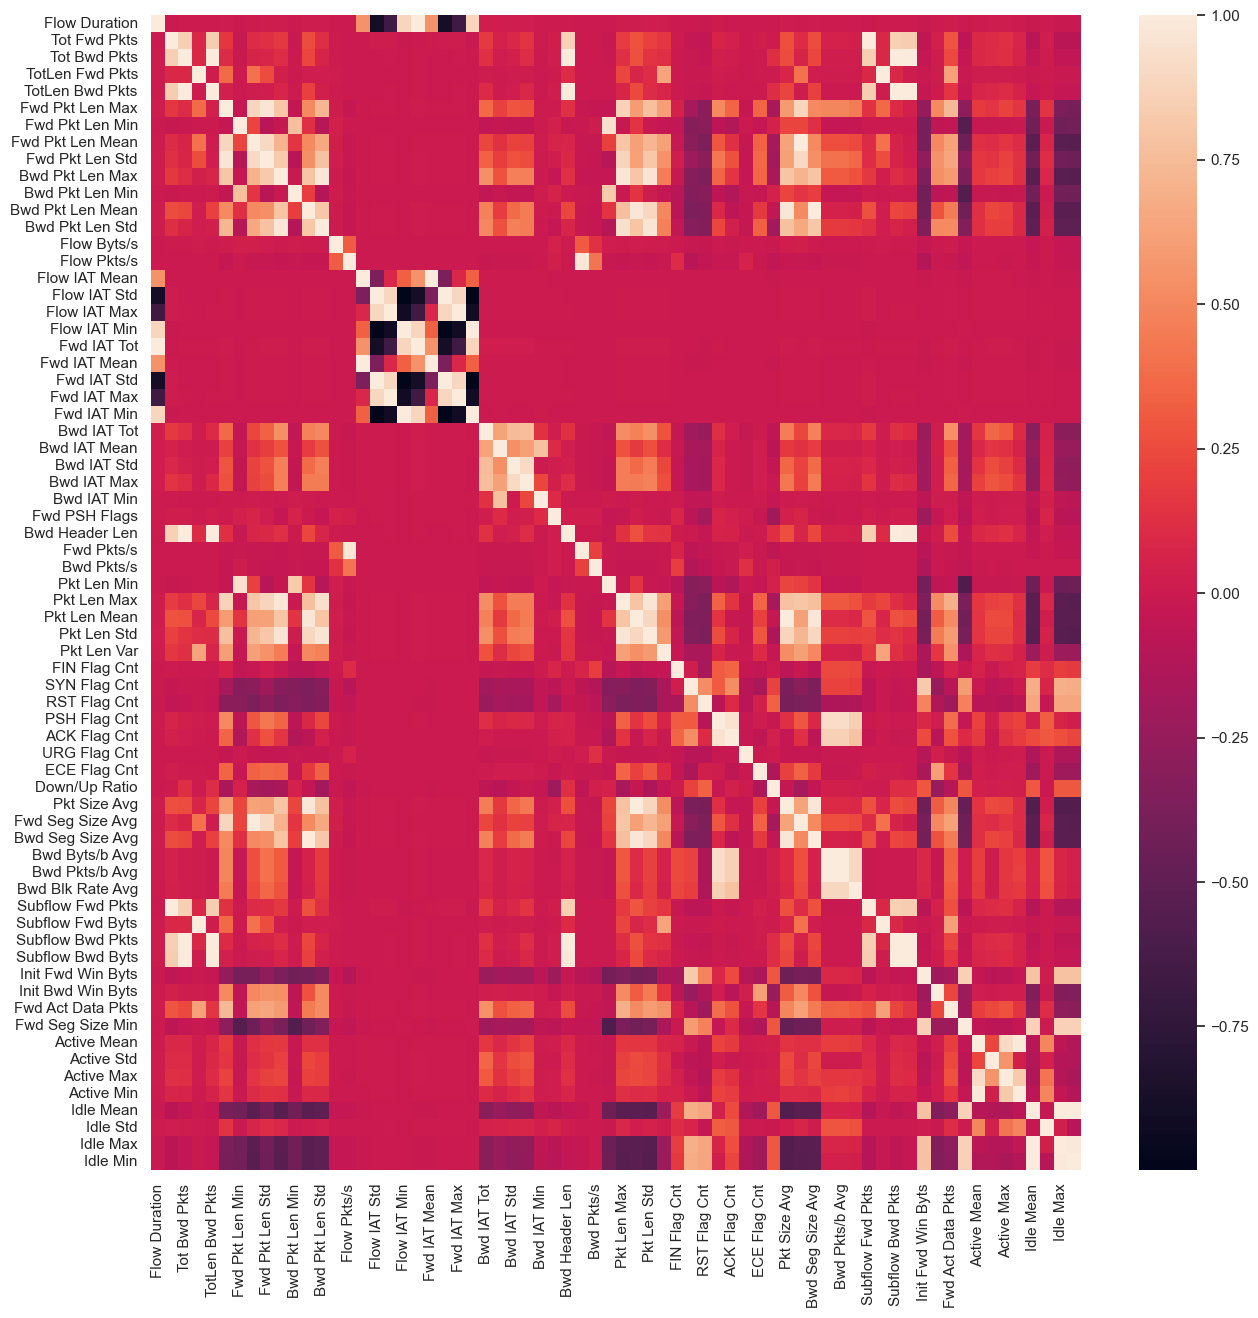

In [9]:
fig = plt.figure(figsize=(15, 15))
sns.set(font_scale=1.0)
ax = sns.heatmap(dataset_corr, annot=False)
fig.savefig(os.path.join('./images', 'correlation matrix.pdf'))

In [10]:
# Create & Apply mask
mask = np.triu(np.ones_like(dataset_corr, dtype=bool))
tri_df = dataset_corr.mask(mask)

# Find Features that meet the threshold
correlated_features = [c for c in tri_df.columns if any(tri_df[c] > 0.98)]
print(correlated_features)
# Drop the highly correlated features
df.drop(labels=correlated_features, axis=1, inplace=True)

['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Bwd Header Len', 'Pkt Len Mean', 'Bwd Byts/b Avg', 'Subflow Bwd Pkts', 'Idle Mean', 'Idle Max']


In [11]:
# drop columns
print(df.info())
train_dataset = df
print(train_dataset['Label'].value_counts())
# df.to_csv('./final_1/final_had_p.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4098189 entries, 0 to 4499999
Data columns (total 52 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Fwd Pkt Len Max    float64
 1   Fwd Pkt Len Min    float64
 2   Fwd Pkt Len Std    float64
 3   Bwd Pkt Len Max    float64
 4   Bwd Pkt Len Min    float64
 5   Bwd Pkt Len Std    float64
 6   Flow Byts/s        float64
 7   Flow Pkts/s        float64
 8   Fwd IAT Tot        float64
 9   Fwd IAT Mean       float64
 10  Fwd IAT Std        float64
 11  Fwd IAT Max        float64
 12  Fwd IAT Min        float64
 13  Bwd IAT Tot        float64
 14  Bwd IAT Mean       float64
 15  Bwd IAT Std        float64
 16  Bwd IAT Max        float64
 17  Bwd IAT Min        float64
 18  Fwd PSH Flags      int64  
 19  Fwd Pkts/s         float64
 20  Bwd Pkts/s         float64
 21  Pkt Len Min        float64
 22  Pkt Len Max        float64
 23  Pkt Len Std        float64
 24  Pkt Len Var        float64
 25  FIN Flag Cnt      

In [12]:
# encode label
labelE = LabelEncoder()
train_dataset['Label'] = labelE.fit_transform(train_dataset['Label'])
train_dataset['Label'].value_counts()
y = train_dataset['Label']
train_dataset = train_dataset.drop(['Label'],axis=1)

In [13]:
# normalize data
sc = StandardScaler()
train_dataset = sc.fit_transform(train_dataset)
train_dataset = pd.DataFrame(train_dataset,columns=df.columns[:-1])

In [14]:
# split data
X_train, X_test, y_train, y_test = train_test_split(train_dataset, y, test_size=0.1, random_state=42)

In [22]:
def re_shape1(X_train,X_test,y_train,y_test):
    X_train = X_train.to_numpy().reshape(len(X_train),X_train.shape[1],1)
    X_test = X_test.to_numpy().reshape(len(X_test),X_test.shape[1],1)
    return X_train,X_test,y_train,y_test


def re_shape(X_train,X_test,y_train,y_test):
    X_train = X_train.to_numpy().reshape(len(X_train),X_train.shape[1]//3,3,1)
    X_test = X_test.to_numpy().reshape(len(X_test),X_test.shape[1]//3,3,1)
    return X_train,X_test,y_train,y_test



def mutil_head_double_layers_evaluate_model(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    # define model conv2D
    input1s = Input(shape=(Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3]))
    conv1 = Conv2D(32,(3,3),activation='relu',padding='same')(input1s)
    conv2 = Conv2D(32,(3,3),activation='relu',padding='same')(conv1)
    pool1 = MaxPooling2D((3,3))(conv2)
    flat1 = Flatten()(pool1)
    dense1 = Dense(256,activation='relu')(flat1)
    drop = Dropout(0.2)(dense1)
    dense2 = Dense(4,activation='softmax')(drop)
    model = Model(inputs=input1s,outputs=dense2)
    #plot model
    plot_model(model, to_file=f'models/{time}/model_{time}.png', show_shapes=True, show_layer_names=True)

    opt = SGD(lr=lr, momentum=0.9)  
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
            #  EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto'),
            #  ModelCheckpoint(filepath=f'models/{time}/model_{time}.h5',monitor='val_loss',save_best_only=True,mode='auto'),
            #  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit(Xtrain,ytrain,epochs=epochs,batch_size=batch_size,validation_data=(Xtest,ytest),callbacks=calls,verbose=1)
    return model


In [19]:
X_train,X_test,y_train,y_test = re_shape(X_train,X_test,y_train,y_test)

In [23]:
# %tensorboard --logdir logs/fit
time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
os.mkdir(f'./models/{time}')
logdir="logs/multi/" + time +'/'
model = mutil_head_double_layers_evaluate_model(time,X_train,y_train,X_test,y_test,logdir,20,512)
model.save(f'models/{time}/model_{time}.h5')

c:\Users\fancyma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
7204/7204 [==============================] - 46s 6ms/step - loss: 0.3990 - accuracy: 0.7455 - val_loss: 0.3463 - val_accuracy: 0.7553
Epoch 2/20
7204/7204 [==============================] - 46s 6ms/step - loss: 0.3468 - accuracy: 0.7559 - val_loss: 0.3424 - val_accuracy: 0.7559
Epoch 3/20
7196/7204 [============================>.] - ETA: 0s - loss: 0.3433 - accuracy: 0.7571

KeyboardInterrupt: 

In [ ]:
da = pd.DataFrame(y_test)
da.value_counts()

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])